# Dataset Collection

## Scraping data from Courera

In [ ]:
# Imports
from bs4 import BeautifulSoup
import requests, json
import pandas as pd
import re

In [ ]:
# Scraping parameters
fetching_list = {
    'Course Name':['Data Science', 'Machine Learning','artificial intelligence'],
    'pages':20 
}

In [ ]:
def create_url(parameters):
    # create base url for all further searches
    target_url = []
    for course in parameters['Course Name']:
      course_title = course.replace(" ","%20")
      target_url.append(f"http://www.coursera.org/search?query={course_title}&index=prod_all_products_term_optimization")
    return target_url, parameters['Course Name']

In [ ]:
def get_job_details(course_soup):
    
    # Get link and title
    course_url = course_soup.a['href']
    
    # Correct for truncated URLs
    course_url = "https://www.coursera.org" + course_url if (course_url.startswith("/")) else course_url
    course_page = requests.get(course_url)
    page_soup = BeautifulSoup(course_page.content,'html.parser')
    
    # Give URL after redirect (ads/analytics etc.)
    course_url = course_page.url 
   
    # Get course title 
    try:
      course_name = page_soup.find(class_='banner-title').get_text()
    except AttributeError:
      course_name = "Not Found "
    
    ### Get the score intro text which contains main content of the course 
    try:
      intro = page_soup.find(class_="max-text-width").get_text()
    except AttributeError:
      intro = "Not Found "
    
    ### Get the related skills of this course
    skills = []
    try:
      skills = [t.get_text() for t in page_soup.select("._rsc0bd.m-r-1s.m-b-1s ._1q9sh65")]
    except AttributeError:
      skills = "Not Found "

     ### Get the score of this course 
     ### only keep the decimal value 
    try:   
      score = page_soup.find(class_="rating-text").get_text()
      score = re.sub(pattern=r'[^0-9.]', repl="", string=score)
    except AttributeError:
      score = "Not Found"

    ### Get the number of rating of this course 
    ### only keep the int value 
    try:
      ratingAmount = page_soup.find(class_="ratings-count-expertise-style").get_text()
      ratingAmount = re.sub(pattern=r'[^0-9.]', repl="", string=ratingAmount)
    except AttributeError:
      ratingAmount = "Not Found"
    
    

    return course_name, intro, skills, score, ratingAmount, course_url

In [ ]:
def scrape(parameters):
    
    # Create base url for all further searches
    base_url, courseNameList = create_url(parameters)
   
    
    # Output list and frame
    output = []
    for index, currentUrl in enumerate(base_url):
      course_title = courseNameList[index].replace(" ","%20")
      print("current course is", courseNameList[index])
      for x in range(0,parameters['pages']):
          if(x==0):
              currentUrl = currentUrl
          else: 
              currentUrl = f"https://www.coursera.org/search?query={course_title}&page={x}&index=prod_all_products_term_optimization"
              
          # get page
          current_page = requests.get(currentUrl,timeout=5)
          page_soup = BeautifulSoup(current_page.content,"html.parser")
          result = page_soup.select(".ais-InfiniteHits-item")
          
          
          for job in page_soup.select(".ais-InfiniteHits-item"):
              course_name, intro, skills, score, ratingAmount, course_url= get_job_details(job)
              output.append([course_name, intro, skills, score, ratingAmount, course_url,courseNameList[index] ])
            
        
    df_output_frame = pd.DataFrame(
        output,columns=['Course Name','Introduction','Skills','Score','Number of Rating', 'Course Url', 'Query Course Name']).sort_values(
        by='Course Name',ascending=False).reset_index(drop=True)

    return df_output_frame

In [ ]:
courses = scrape(fetching_list)


current course is Data Science
current course is Machine Learning
current course is artificial intelligence


In [ ]:
display(courses.head())


,Course Name,Introduction,Skills,Score,Number of Rating,Course Url,Query Course Name
0,機器學習技法 (Machine Learning Techniques),Not Found,[],5.0,Not Found,https://www.coursera.org/learn/machine-learnin...,artificial intelligence
1,機器學習技法 (Machine Learning Techniques),Not Found,[],5.0,10,https://www.coursera.org/learn/machine-learnin...,Machine Learning
2,機器學習基石下 (Machine Learning Foundations)---Algor...,Not Found,[],4.9,Not Found,https://www.coursera.org/learn/ntumlone-algori...,artificial intelligence
3,機器學習基石下 (Machine Learning Foundations)---Algor...,Not Found,[],4.9,280,https://www.coursera.org/learn/ntumlone-algori...,Machine Learning
4,機器學習基石上 (Machine Learning Foundations)---Mathe...,Not Found,"[Decision Stump, Perceptron, Machine Learning,...",4.9,791,https://www.coursera.org/learn/ntumlone-mathem...,Machine Learning


## Save to Excel

In [ ]:
with pd.ExcelWriter('Coursera.xlsx',options={'strings_to_urls': False}) as writer:
    courses.to_excel(writer,index=False)

## Scrapping data from Indeed 

In [ ]:
# Scraping parameters
fetching_list = {
    'job_title':['Data Scientist', 'Data Engineer', 'Data Analyst' ],
    'location':'Canada',
    'pages':30 
}

In [ ]:
#### create the base searching url
def createBaseUrl(parameters):
    targetUrl = []
    for title in parameters['job_title']:
      myTitle = title.replace(" ","+")
      place = parameters['location'].replace(" ","+")
      targetUrl.append(f"https://www.indeed.ca/jobs?q={myTitle}&l={place}")
    return targetUrl, parameters['job_title']

In [ ]:
def get_desciption(pageSoup):
    try:
      description = pageSoup.find(id="jobDescriptionText").get_text()
      description = re.sub(pattern=r'[\!"#$%&\*+,-./:;<=>?@^_`()|~=]', repl="", string=description)
      # tokenized_description=word_tokenize(description)
      # description=[t for t in tokenized_description if not t in stopWords] 
    except AttributeError:
      description = "Not Found" 
    
    return description

In [ ]:
def getDetails(job,parameters):
    
    # Get link and title
    job_url = job.find(class_='title').a['href']
    
    # Correct for truncated URLs
    job_url = "https://www.indeed.ca" + job_url if (job_url.startswith("/")) else job_url
    job_page = requests.get(job_url)
    pageSoup = BeautifulSoup(job_page.content,'html.parser')
    
  
    job_url = job_page.url 
    print(job_url)
    # Get job title and company name
    try:
      title = job.find(class_='title').a['title']
    except AttributeError:
      title = "Not Found"
    
    try:
      company = pageSoup.find(class_="icl-u-lg-mr--sm").get_text()
    except AttributeError:
      company = "Not Found"

    try:
      location = pageSoup.find_all('div', 
              {'class':"jobsearch-InlineCompanyRating icl-u-xs-mt--xs jobsearch-DesktopStickyContainer-companyrating"})[0].text.split("-")[1]
    except (AttributeError, IndexError) as e  :
      location = "Not Found"
    # print(location)
    
    
    # Get description, rating and present keywords
    description = get_desciption(pageSoup)
    # print(title, " ", company)
    return title, company,location, job_url, description

In [ ]:
def indeedScraping(parameters):
    
    # Create base url for all further searches
    base_url, queryTitle = createBaseUrl(parameters)
    
   ### result list which will be convert to df and to csv files
    result = []
    for index, currentUrl in enumerate(base_url):
      for x in range(0,parameters['pages']):
          if(x==0):
              pageNumber = ""
          else: 
              pageNumber = "&start=" + str(x*10)
              
          # get current page
          currentUrl = currentUrl+pageNumber
          print(currentUrl, x)
          current_page = requests.get(currentUrl,timeout=5)
          page_soup = BeautifulSoup(current_page.content,"html.parser")
          
          for job in page_soup.select(".jobsearch-SerpJobCard"):
              title, company, location, url, description= getDetails(job,parameters)
              result.append([title,company, location,description,url, queryTitle[index]])
              
    ### convert result dict to result dataframe 
    resultDf = pd.DataFrame(
        result,columns=['Job Title','Company','Location','Description','Job URL', 'Query Title']).sort_values(
        by='Job Title',ascending=False).reset_index(drop=True)

    return resultDf

In [ ]:
jobs = indeedScraping(fetching_list)


https://www.indeed.ca/jobs?q=Data+Scientist&l=Canada 0
https://ca.indeed.com/viewjob?jk=c118d2f7459bfd0c&from=serp&vjs=3
https://ca.indeed.com/viewjob?jk=877fae9483d8a538&from=serp&vjs=3
https://ca.indeed.com/viewjob?jk=11395718c7b9f23c&from=serp&vjs=3
https://ca.indeed.com/viewjob?jk=4f95187291fd2fc7&from=serp&vjs=3
https://ca.indeed.com/viewjob?jk=c5ea013ea16975bd&from=serp&vjs=3
https://ca.indeed.com/viewjob?jk=1be320907491bf2a&from=serp&vjs=3
https://ca.indeed.com/viewjob?jk=5005503167bf5934&from=serp&vjs=3
https://ca.indeed.com/viewjob?jk=022194a6f08b395c&from=serp&vjs=3
https://ca.indeed.com/viewjob?jk=17b0d6008288be29&from=serp&vjs=3
https://ca.indeed.com/viewjob?jk=d20604db42f358ae&from=serp&vjs=3
https://ca.indeed.com/viewjob?jk=60ca003c0b7142c8&from=serp&vjs=3
https://ca.indeed.com/viewjob?jk=04460ba973e07880&from=serp&vjs=3
https://ca.indeed.com/viewjob?jk=f6d128507d45e87a&from=serp&vjs=3
https://ca.indeed.com/viewjob?jk=8b77159487069f52&from=serp&vjs=3
https://ca.indeed.com

In [ ]:
display(jobs.head())


,Job Title,Company,Location,Description,Job URL,Query Title
0,"Specialist, Data Science and Machine Learning ...",Gartner,"Quebec City, QC",What makes Gartner Research Advisory a GREAT ...,https://ca.indeed.com/viewjob?jk=6380e96c4bffa...,Data Scientist
1,"Specialist, Data Science and Machine Learning ...",Gartner,"Quebec City, QC",What makes Gartner Research Advisory a GREAT ...,https://ca.indeed.com/viewjob?jk=6380e96c4bffa...,Data Scientist
2,"Specialist, Data Science and Machine Learning ...",Gartner,"Quebec City, QC",What makes Gartner Research Advisory a GREAT ...,https://ca.indeed.com/viewjob?jk=6380e96c4bffa...,Data Scientist
3,"Specialist, Data Science and Machine Learning ...",Not Found,Not Found,Not Found,https://ca.indeed.com/rc/clk?jk=6380e96c4bffaf...,Data Scientist
4,"Specialist, Data Science and Machine Learning ...",Gartner,"Quebec City, QC",What makes Gartner Research Advisory a GREAT ...,https://ca.indeed.com/viewjob?jk=6380e96c4bffa...,Data Scientist


In [ ]:
with pd.ExcelWriter('Indeed.xlsx',options={'strings_to_urls': False}) as writer:
    jobs.to_excel(writer,index=False)

# Part 1

In [ ]:
import numpy as np
import pandas as pd
import re
import html
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.tag import PerceptronTagger
from nltk.data import find
from scipy.cluster.hierarchy import dendrogram, linkage
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("averaged_perceptron_tagger")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

### Load CSV

Load csv for technical and business oriented jobs:

**Technical jobs:**

1.   2018 ML&DS Survey (Kaggle, SUrvey)
2.   2019 ML&DS Survey (Kaggle, Survey)
3.   Data Analyst Jobs (Kaggle, Glassdoor)
4.   Data Engineer Jobs (Kaggle, Glassdoor)
5.   Data Scientist Jobs (Kaggle, Glassdoor)
6.   Technical_Coursera (Web Scrapped)
7.   Technical_Indeed (Web Scrapped)

**Business jobs:**


1.   Business_Coursera (Web Scrapped)
2.   Business_Indeed (Web Scrapped)
3.   BusinessAnalyst (Kaggle, Glassdoor)


In [ ]:
#load technical data
survey_2018_df = pd.read_csv('multipleChoiceResponses.csv')    # 2018 ML&DS Survey
survey_2019_df = pd.read_csv('multiple_choice_responses.csv')  # 2019 ML&DS Survey
da_df = pd.read_csv('DataAnalyst.csv', index_col=0)            # Data Analyst Jobs
de_df = pd.read_csv('DataEngineer.csv')                        # Data Engineer Jobs
ds_df = pd.read_csv('DataScientist.csv', index_col=1)          # Data Scientist Jobs
ds_df = ds_df.drop(labels=['Unnamed: 0'], axis=1)
tec_coursera_df = pd.read_csv('Technical_Coursera.csv')        # Coursera technical
tec_indeed_df = pd.read_csv('Technical_Indeed.csv')            # Indeed technical

#load business data
bus_coursera_df = pd.read_csv('Business_Coursera.csv')        # Coursera business
bus_indeed_df = pd.read_csv('Business_Indeed.csv')            # indeed business
ba_df = pd.read_csv('BusinessAnalyst.csv')                    # Business Analyst Jobs

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,2,8,10,21,23,24,25,26,27,28,44,56,64,83,85,87,107,109,123,125,150,157,172,174,194,210,218,219,223,246,249,262,264,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,304,306,325,326,329,341,368,371,384,385,389,390,391,393,394) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,3,7,19,34,47,49,50,51,52,53,54,68,81,94,96,109,115,130,139,147,154,167,180,193,206,219,232,245) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Dataframes concat

In [ ]:
# technical jobs
# glassdoor technical df
tec_glassdoor_df = pd.concat([da_df, de_df, ds_df], axis=0) # concat glassdoor df
tec_glassdoor_df = tec_glassdoor_df.drop_duplicates(subset='Job Description') # remove duplicate descriptions
tec_glassdoor_df = tec_glassdoor_df.rename(columns={"Job Description": "Job_description"})

# indeed technical df
tec_indeed_df = tec_indeed_df.drop_duplicates().reset_index(drop=True)
tec_indeed_df = tec_indeed_df[['Job Title', 'Description']]
tec_indeed_df = tec_indeed_df.rename(columns={"Description": "Job_description"})

# concat the column of job description
tec_df = tec_glassdoor_df[['Job Title', 'Job_description']]
tec_df = pd.concat([tec_df, tec_indeed_df], axis=0)
tec_df = tec_df.drop_duplicates().reset_index(drop=True)

print('We have {} data for technical jobs.'.format(len(tec_df)))
tec_df.head()

We have 7119 data for technical jobs.


,Job Title,Job_description
0,"Data Analyst, Center on Immigration and Justic...",Are you eager to roll up your sleeves and harn...
1,Quality Data Analyst,Overview\n\nProvides analytical and technical ...
2,"Senior Data Analyst, Insights & Analytics Team...",We’re looking for a Senior Data Analyst who ha...
3,Data Analyst,Requisition NumberRR-0001939\nRemote:Yes\nWe c...
4,Reporting Data Analyst,ABOUT FANDUEL GROUP\n\nFanDuel Group is a worl...


In [ ]:
# business jobs
bus_indeed_df = bus_indeed_df.drop_duplicates().reset_index(drop=True)
bus_indeed_df = bus_indeed_df[['Job Title', 'Description']]
bus_indeed_df = bus_indeed_df.rename(columns={"Description": "Job_description"})

# concat the column of job description
ba_df = ba_df.rename(columns={"Job Description": "Job_description"})
bus_df = ba_df[['Job Title', 'Job_description']]

# concat the column of job description
bus_df = pd.concat([bus_df, bus_indeed_df], axis=0)
bus_df = bus_df.drop_duplicates().reset_index(drop=True)

print('We have {} data for business jobs.'.format(len(bus_df)))
bus_df.head()

We have 4069 data for business jobs.


,Job Title,Job_description
0,Business Analyst - Clinical & Logistics Platform,Company Overview\n\n\nAt Memorial Sloan Ketter...
1,Business Analyst,We are seeking for an energetic and collaborat...
2,Data Analyst,"For more than a decade, Asembia has been worki..."
3,"Information Security Analyst, Incident Response",Job Description Summary\nThe Information Secur...
4,Analyst - FP&A Global Revenue,Magnite is the world's largest independent sel...


## Text preprocessing

In [ ]:
# Remove all html tags and attributes (i.e., /<[^>]+>/))
def html_cleaner(text):

  # Using a regex, clean everything inside <>
  cleaner = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
  # apply cleaner to the input text
  cleaned_text = re.sub(cleaner, '', text)
  return cleaned_text

# Remove all URLs
def url_cleaner(text):
  # Using a regex, clean all url
  cleaner = re.compile('\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*')
  # apply cleaner to the input text
  cleaned_text = re.sub(cleaner, '', text)
  return cleaned_text

# Remove non-letter and white space
def non_letter_cleaner(text):
  cleaned_text = re.sub(r'[^a-zA-Z ]+', ' ', text)
  return cleaned_text

def white_space_cleaner(text):
  cleaned_text = re.sub(r'\s+', ' ', text)
  return cleaned_text

# Remove stope words
def stopword_cleaner(text):
  # set stopwords in English
  stop_words = set(stopwords.words("english"))
  # use Reg to spilit the string and remove stopwords
  desp = [word for word in re.findall(r'\w+', text) if word not in stop_words]
  return ' '.join(desp)

# Tokenization & Lemmatization
def lemmatization(text):
  # tokenlization
  tokenizer = RegexpTokenizer(r'\w+')
  lemmatizer = nltk.WordNetLemmatizer()
  text_words = tokenizer.tokenize(text)
  # lemmatization
  desp = [lemmatizer.lemmatize(word) for word in text_words]
  return desp

def Tokenization(text):
  # tokenlization
  tokenizer = RegexpTokenizer(r'\w+')
  text_words = tokenizer.tokenize(text)
  # lemmatization
  desp = [word for word in text_words]

  # add ' ' between words
  return desp

#-------------------------------------------------------------------------------
def text_preprecessing(df, column):
    # step1: Remove all html tags and attributes (i.e., /<[^>]+>/))
    df[column] = df[column].apply(html_cleaner)

    # Step 2: Replace HTML character codes with ASCII equivalent
    df[column] = html.unescape(df[column])

    # Step 3: Remove all URLs
    df[column] = df[column].apply(url_cleaner)

    # Step 4: Lowercase all characters in the text
    df[column] = df[column].str.lower()

    # Step 5: Remove non-letter
    df[column] = df[column].apply(non_letter_cleaner)

    # Step 6: Remove white space
    df[column] = df[column].apply(white_space_cleaner)

    # Step 7: Remove stope words
    df[column] = df[column].apply(stopword_cleaner)

    # Step 8: Tokenization & Lemmatization
    df[column] = df[column].apply(lemmatization)
    # make a untoken copy 
    df['untoken'] = df[column].apply(lambda word:" ".join(word))

    return df

In [ ]:
# apply text preprocessing to technical and business df
tec_df = text_preprecessing(tec_df, 'Job_description')
bus_df = text_preprecessing(bus_df, 'Job_description')

## Extract technical and business skills from Coursera df

In [ ]:
#  grammatical tagging is the process of marking up a word in a text (corpus) as corresponding to a particular part of speech
tagger = PerceptronTagger()

# Determine the most appropriate tag sequence for the given token sequence, 
# and return a corresponding list of tagged tokens. A tagged token is encoded as a tuple (token, tag).
pos_tag = tagger.tag

grammar_1 = r"""
    NBAR:
        {<NN.*>*<NN.*>}  # Nouns and Adjectives, terminated with Nouns
        
    NP:
        {<NBAR>}
        {<NBAR><IN><NBAR>}  # Above, connected with in/of/etc...
"""

grammar_2 = r"""
    NBAR:
        {<NN.*|JJ>*<NN.*>}  # Nouns and Adjectives, terminated with Nouns

    NP:
        {<NBAR>}
        {<NBAR><IN><NBAR>}  # Above, connected with in/of/etc...
"""

# chunking, which segments and labels multi-token sequences 
chunker_1 = nltk.RegexpParser(grammar_1)
chunker_2 = nltk.RegexpParser(grammar_2)

# ------------------------------------------------------------------------------------
# to make the results more useable, we clean up the tree results shown above. 
lemmatizer = nltk.WordNetLemmatizer()
stemmer = nltk.stem.porter.PorterStemmer()
stopword_list = stopwords.words('english')

# generator, create item one a time
def get_terms(tree):
    for leaf in leaves(tree):
        term = [normalise(w) for w,t in leaf if acceptable_word(w) ]
        # Phrase only
        if len(term)>1:
            yield term # Yield can produce a sequence of values. We should use yield when we want to iterate over a sequence, but don’t want to store the entire sequence in memory

# generator, generate leaves one by one
def leaves(tree):
    """Finds NP (nounphrase) leaf nodes of a chunk tree."""
    # JJ: adjective    RB: Adverb    NP: noun phrase(defined in grammar)
    for subtree in tree.subtrees(filter = lambda t: t.label()=='NP' or t.label()=='JJ' or t.label()=='RB'):
        yield subtree.leaves()

# stemming, lematizing, lower case... 
def normalise(word,lemmatizer=lemmatizer, stemmer=stemmer):
    """Normalises words to lowercase and stems and lemmatizes it."""
    word = word.lower()
    # word = stemmer.stem(word)
    word = lemmatizer.lemmatize(word)
    return word

# stop-words and length control
def acceptable_word(word, stopword_list=stopword_list):
    """Checks conditions for acceptable word: length, stopword."""
    accepted = bool(2 <= len(word) <= 40
        and word.lower() not in stopword_list)
    return accepted

# Flatten phrase lists to get tokens for analysis
def flatten_phrase_lists(npTokenList):
    finalList =[]
    for phrase in npTokenList:
        token = ''
        for word in phrase:
            token += word + ' '
        finalList.append(token.rstrip())
    return finalList

# ------------------------------------------------------------------------------------
# split skills from single str
def splitter(string): 
    string = string.lower()
    string = string.split("['")
    string = string[1].split("']")[0]
    string = string.split("', '")
    return string


def getTopKNP(df, kNPs, chunker, column):

    counter = Counter()
    reviews = df[column].values

    for review in reviews:
            counter.update(flatten_phrase_lists([word
                            for word 
                            in get_terms(chunker.parse(pos_tag(re.findall(r'\w+', review)))) 
                            ]))
    topk = counter.most_common(kNPs)
    topk_df = pd.DataFrame(topk, columns=['word', 'frequency'])
    return topk_df

def getTopKWords(df, kwords, column):

  counter = Counter()
  texts = df[column].values

  for text in texts:
          counter.update([word for word in text if len(word) > 2])
  topk = counter.most_common(kwords)
  topk_df = pd.DataFrame(topk, columns=['word', 'frequency'])
  return topk_df


In [ ]:
def extract_skills(df, base_freq, target='technical'):
    """
    This function is used to extract skills as words and Noun pharses from Coursera df
    df: dataframe from coursera
    base_freq: baseline frequency, and words/NPs lower than it will be dropped out 
    target: either technical or business
    """

    # remove duplicate rows, and target on skill column
    df = df.drop_duplicates(subset='Course Name')[['Skills']]

    # remove rows with empty list
    df = df[df.astype(str)['Skills'] != '[]']
    df = df.reset_index(drop=True)

    # convert string to skill list
    if target == 'technical':
        df = df.drop(labels=[158,215], axis=0).reset_index(drop=True)

    # get skills before NLP
    df['original'] = df['Skills'].apply(splitter)

    # apply NLP preprocessing
    df = text_preprecessing(df, 'Skills')

    # get top-k most frequent words based on NLP
    NLP_word_df = getTopKWords(df, 3000, 'Skills') # top 3000 most frequent words

    # get top-k most frequent words(NP) based on original skill 
    original_word_df = getTopKWords(df, 3000, 'original') # top 3000 most frequent words

    # get top-k most frequent noun phrase based on NLP
    NLP_NP_df = getTopKNP(df, 3000, chunker_1, 'untoken')

    # concat three df, remove duplicates
    skill_df = pd.concat([NLP_word_df, original_word_df, NLP_NP_df])
    skill_df = skill_df.drop_duplicates(subset='word')

    # sort by frequency and remove the words(NP) with frequency lower than baseline
    skill_df = skill_df.sort_values('frequency', ascending=False)
    skill_df = skill_df[skill_df['frequency']>=base_freq]

    return df, skill_df


Get technical and business skills from Coursera

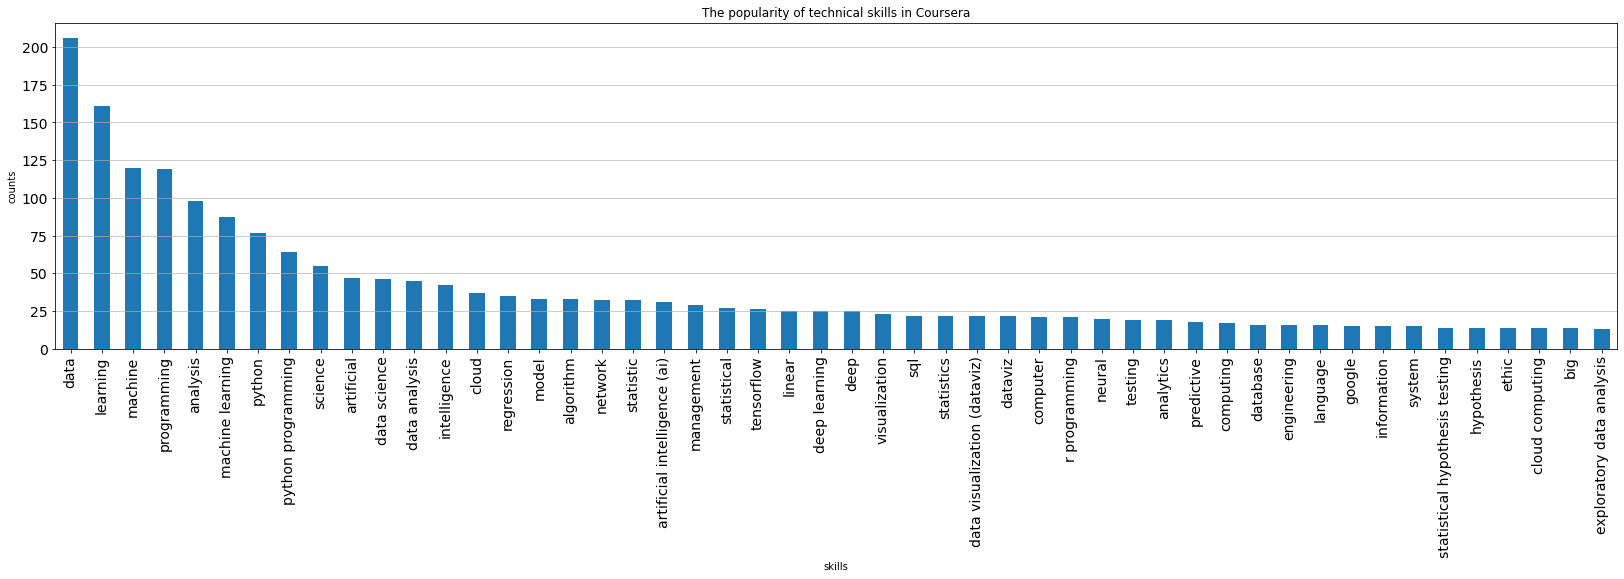

In [ ]:
# technical skills
tec_coursera_df, tec_skill_coursera_df = extract_skills(tec_coursera_df, 3, target='technical')
bus_coursera_df, bus_skill_coursera_df = extract_skills(bus_coursera_df, 3, target='business')


bar_plot_df = tec_skill_coursera_df.groupby('word').sum().sort_values('frequency',ascending=False)
# plot top 50 skills
bar_plot_df.iloc[0:50].plot(kind='bar',legend=False,rot=90,xlabel='skills',figsize=(28,6), 
                 fontsize=14, ylabel='counts', title='The popularity of technical skills in Coursera')
plt.grid(axis='y', alpha=0.8)

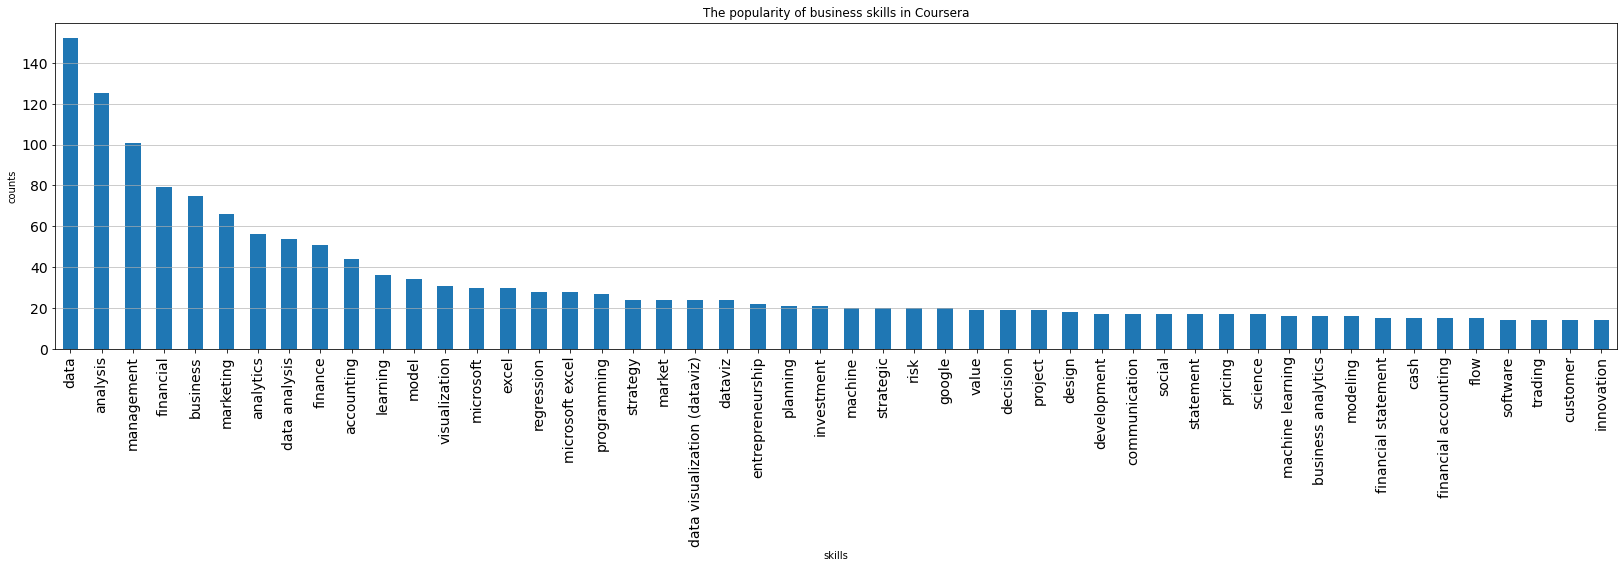

In [ ]:
bar_plot_df = bus_skill_coursera_df.groupby('word').sum().sort_values('frequency',ascending=False)
# plot top 50 skills
bar_plot_df.iloc[0:50].plot(kind='bar',legend=False,rot=90,xlabel='skills', figsize=(28,6), 
                 fontsize=14, ylabel='counts', title='The popularity of business skills in Coursera')
plt.grid(axis='y', alpha=0.8)

## Extract technical and business skills from job descriptions (TF-IDF)

This process contains thress steps:


1.   Using TF-IDF get words and N-grams from both technical and business df. Then drop the common words which showed up in both df.

2.   Make a projection from the TF-IDF to the coursera skills. Only the words/NP exist in coursera df will be kept.

3.   Do manual filtering. Remove some words based on manual selection.



### Step 1: Cross-Filtering: remove common words in both technical and business job descriptions

In [ ]:
def TFIDF(df, column, select, stopword_list=[]):
    """
    This function is used to generate TFIDF skill df
    exception: list of exception words, we want to keep
    select: Noune for word, (2,2) from N-grams
    """
    # generate tfidf matrix 
    if select == 'word':
        tv = TfidfVectorizer(analyzer='word', stop_words=stopword_list, ngram_range=(1,1))
    elif select == 'n_grams':
        tv = TfidfVectorizer(analyzer='word', stop_words=None, ngram_range=(2,2))

    tv_matrix = tv.fit_transform(df[column].values)
    TFIDF_score = np.sum(tv_matrix, axis=0)

    TFIDF_df = pd.DataFrame([tv.get_feature_names(), TFIDF_score.tolist()[0]]).T
    TFIDF_df.columns=['word','score']
    TFIDF_df = TFIDF_df.sort_values('score', ascending=False)

    if select == 'n_grams':
        TFIDF_df = TFIDF_df[~TFIDF_df['word'].isin(stopword_list)]
    return TFIDF_df

def get_stopwords(df, column, num, exception, select=None):
    """
    This function is used to generate stopwords we want to ignore
    num: number of stopwords to keep based on tfidf score
    exception: list of exception words we want to keep
    """
    df = TFIDF(df, column, select)
    stopwords_list = df.iloc[0:num]['word'].values.tolist()

    # remove the exceptions from stopword list
    stopwords_list = [word for word in stopwords_list if word not in exception]
    return stopwords_list


For technical skills




In [ ]:
# get technical stopwords from business df
tec_exception = ['python', 'feature', 'sql', 'ibm', 'statistic']

# dictionary to hold stopwords for technical and business skills
stopwords_dic = {}
stopwords_dic['tec_word'] = get_stopwords(bus_df, 'untoken', 1000, tec_exception, select='word')
stopwords_dic['tec_ngram'] = get_stopwords(bus_df, 'untoken', 500, tec_exception, select='n_grams')

# Cross-Filtering: technical word and N-grams skills
tec_word_skill = TFIDF(tec_df, 'untoken', select='word', stopword_list=stopwords_dic['tec_word'])
tec_gram_skill = TFIDF(tec_df, 'untoken', select='n_grams', stopword_list=stopwords_dic['tec_ngram'])

For business skills


In [ ]:
# get technical stopwords from business df
bus_exception = ['python', 'excel', 'sql', 'ibm', 'statistic', 'stakeholder']

# dictionary to hold stopwords for business and business skills
stopwords_dic['bus_word'] = get_stopwords(tec_df, 'untoken', 1000, bus_exception, select='word')
stopwords_dic['bus_ngram'] = get_stopwords(tec_df, 'untoken', 1000, bus_exception, select='n_grams')

# Cross-Filtering: business word and N-grams skills
bus_word_skill = TFIDF(bus_df, 'untoken', select='word', stopword_list=stopwords_dic['bus_word'])
bus_gram_skill = TFIDF(bus_df, 'untoken', select='n_grams', stopword_list=stopwords_dic['bus_ngram'])

### Step 2: Projection on skills from Coursera 

Prepare Coursera skill lists for tachnical and business skills

In [ ]:
# extract skills from coursera df based on TF-IDF
# technical
tec_coursera_skill_list = []
tec_word_coursera = TFIDF(tec_coursera_df, 'untoken', select='word', stopword_list=stopwords_dic['tec_word'])
tec_word_coursera = tec_word_coursera[tec_word_coursera['score']>=1]
tec_coursera_skill_list += tec_word_coursera['word'].values.tolist()

tec_gram_coursera = TFIDF(tec_coursera_df, 'untoken', select='n_grams', stopword_list=stopwords_dic['tec_ngram'])
tec_gram_coursera = tec_gram_coursera[tec_gram_coursera['score']>=2]
tec_coursera_skill_list += tec_gram_coursera['word'].values.tolist()
# add skills we get from previous part
tec_coursera_skill_list +=  tec_skill_coursera_df['word'].values.tolist() 
# remove some duplicates
tec_coursera_skill_list = list(set(tec_coursera_skill_list)) 

# business
bus_coursera_skill_list = []
bus_word_coursera = TFIDF(bus_coursera_df, 'untoken', select='word', stopword_list=stopwords_dic['bus_word'])
bus_word_coursera = bus_word_coursera[bus_word_coursera['score']>=1]
bus_coursera_skill_list += bus_word_coursera['word'].values.tolist()

bus_gram_coursera = TFIDF(bus_coursera_df, 'untoken', select='n_grams', stopword_list=stopwords_dic['bus_ngram'])
bus_gram_coursera = bus_gram_coursera[bus_gram_coursera['score']>=1]
bus_coursera_skill_list += bus_gram_coursera['word'].values.tolist()
# add skills we get from previous part
bus_coursera_skill_list +=  bus_skill_coursera_df['word'].values.tolist() 
# remove some duplicates
bus_coursera_skill_list = list(set(bus_coursera_skill_list)) 

filtering based on  Coursera skill lists

In [ ]:
# assign new tfidf score to grams
def gram_new_score(word_df, gram_df, threshold):
    # initially remove some ununusual grams
    gram_df = gram_df[gram_df['score']>=threshold]
    gram_df_copy = gram_df.copy()
    # assign new tfidf score to grams
    for i in range(0, len(gram_df)):
        score_list = []
        # check every term in each gram
        for term in gram_df['token'][i]:
            # if the term exists in word df, then assign the score of the word to gram
            if term in  word_df['word'].values.tolist():
                index = word_df.index[word_df['word'] == term][0]
                score_list.append(word_df['score'][index])
        if len(score_list) != 0:
            avg_score = sum(score_list)/len(score_list)
            gram_df_copy['score'][i] = avg_score

    gram_df_copy = gram_df_copy.sort_values('score', ascending=False)
    return gram_df_copy

# remove words skills which are already in gram skills
def merge_word_gram(word_df, gram_df, threshold_1, threshold_2):

    # get all words from the N-grams
    grams_to_words = []
    for gram in gram_df['token'].values:
        grams_to_words +=gram

    # remove duplicates
    grams_to_words = list(set(grams_to_words))

    # filter out some grams with low tfidf score
    gram_df = gram_df[gram_df['score']>=threshold_1]
    
    # remove some duplicated words which included in grams
    word_df = word_df[~word_df.word.isin(grams_to_words)].reset_index(drop=True)
    # filter out some words with low tfidf score
    word_df = word_df[word_df['score']>=threshold_2]

    # merge two df
    final_df = pd.concat([word_df, gram_df[['word','score']]])
    final_df = final_df.sort_values('score', ascending=False)
    final_df = final_df.reset_index(drop=True)
    return final_df

Technical

In [ ]:
# words filtering, skill must exist in coursera skill df
tec_word_skill = tec_word_skill[tec_word_skill['word'].isin(tec_coursera_skill_list)].reset_index(drop=True)

# N-grams filtering, skill must exist in coursera skill df
tec_gram_skill = tec_gram_skill[tec_gram_skill['word'].isin(tec_coursera_skill_list)].reset_index(drop=True)

# assign new scores to grams
tec_gram_skill['token'] = tec_gram_skill['word'].apply(Tokenization)
tec_gram_skill_new = gram_new_score(tec_word_skill, tec_gram_skill, 2.99)

# # merge word and grams skills
tec_skill_df = merge_word_gram(tec_word_skill, tec_gram_skill_new, 3.5, 10)


Business

In [ ]:
# words filtering
bus_word_skill = bus_word_skill[bus_word_skill['word'].isin(bus_coursera_skill_list)].reset_index(drop=True)

# N-grams filtering 
bus_gram_skill = bus_gram_skill[bus_gram_skill['word'].isin(bus_coursera_skill_list)].reset_index(drop=True)

# assign new scores to grams
bus_gram_skill['token'] = bus_gram_skill['word'].apply(Tokenization)
bus_gram_skill = gram_new_score(bus_word_skill, bus_gram_skill, 1)

# merge word and grams skills
bus_skill_df = merge_word_gram(bus_word_skill, bus_gram_skill, 2, 2)


## Manual filtering

In [ ]:
manual_dic = {}
manual_dic['technical'] = ['analysis machine', 'intelligence machine', 'applied',
                           'coding', 'trading', 'transfer', 'privacy', 'simple'
                     'extraction', 'series', 'interpretation', 'short', 'image', 
                     'logic','mean','treatment','spreadsheet','virtual','ethic',
                     'wrangling','language processing','science data','distributed']

manual_dic['business'] = ['income','fit','solver','log', 'return', 'informed',
                         'construction','price','mix','normal','theory','win',
                         'lookup','lp','decide','renewable','exit','disruptive',
                          'identification', 'distribution', 'map', 'six', 'chart',
                          'visual', 'interpretation', 'style', 'series']

tec_skill_df = tec_skill_df[~tec_skill_df['word'].isin(manual_dic['technical'])]
tec_skill_df = tec_skill_df.reset_index(drop=True)
tec_skill_df.T                                              

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68
word,sql,machine learning,python programming,pipeline,statistic data,algorithm,azure,apache spark,ai,predictive analytics,ml,hive,feature engineering,big data,storage,javascript,regression,cloud computing,api,classification,artificial intelligence,mysql,natural language,extraction,mathematical,modelling,selection,graph,ibm,simple,clustering,tensorflow,debugging,panda,data manipulation,cyber,text,informatics,hypothesis testing,neural network,matlab,data cleansing,pivot table,theory,deep learning,tree,linear,bioinformatics,data structure,html,numpy,confidence,rdbms,bigquery,exploratory,data architecture,cybersecurity,probability,supervised,kera,cognos,github,inference,random forest,computer vision,google cloud,cloud platform,business analytics,reinforcement learning
score,212.77,160.347,155.009,120.735,99.9509,88.964,70.4623,69.9924,63.6822,63.4318,58.5946,57.9964,49.3582,48.8712,39.31,38.2687,35.5102,35.1926,32.7234,29.1111,28.3266,27.6912,26.9163,25.4462,25.3336,22.0008,21.7717,20.6229,20.4993,20.3604,20.3268,20.2343,19.7717,19.7499,19.7467,19.5583,19.5257,19.4585,18.9926,18.9406,18.2313,18.1395,17.5075,16.7074,16.0709,15.9914,15.4342,14.9352,14.6926,14.3528,14.2226,13.7653,13.3341,12.9307,12.8397,11.9935,11.2739,11.1976,11.1007,11.0321,10.0957,10.0505,10.0327,9.36138,8.79715,8.54305,8.26307,7.05976,6.1784


In [ ]:
bus_skill_df = bus_skill_df[~bus_skill_df['word'].isin(manual_dic['business'])]
bus_skill_df = bus_skill_df.reset_index(drop=True)
bus_skill_df.T    

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69
word,sql,excel data,gap,python,statistic,forecast,inventory,pricing,cash flow,balance sheet,kpis,aid,pivot table,trade,elicitation,lean,spreadsheet,sigma,measurement,change management,ethic,equity,negotiation,budgeting,ibm,promotion,lending,segmentation,stock,cognos,modelling,investor,behavioral,engine,data cleansing,app,competition,simulation,financial analysis,terminology,management business,analysis business,business model,hypothesis,estimation,valuation,venture,graphic,philosophy,costing,financial management,sport,benchmarking,microstrategy,financial statement,breakdown,accrual,exploratory,rpa,market research,marketing strategy,financial modeling,social medium,business plan,informatics,value proposition,digital marketing,project planning,positioning,rdbms
score,85.0681,62.9123,27.469,23.9506,22.907,18.8243,17.3983,16.8315,15.6814,11.8706,11.5431,11.0152,10.4558,10.2073,10.1501,9.95497,9.93273,9.5674,9.44251,9.32254,9.08204,8.5214,8.16994,7.79255,7.66299,7.52771,7.47033,6.81937,6.65798,6.34226,6.23593,6.19744,6.19372,6.15683,5.84267,5.68458,5.39907,5.03513,4.96607,4.89398,4.89316,4.72364,4.66995,4.42842,4.39143,4.344,4.20711,3.99194,3.81041,3.51125,3.43281,3.36443,3.36279,3.27817,3.22296,3.20791,3.14821,2.95089,2.85208,2.84784,2.72322,2.61907,2.58411,2.53184,2.43315,2.42823,2.34915,2.20154,2.07959,2.02381


### Skills visulization

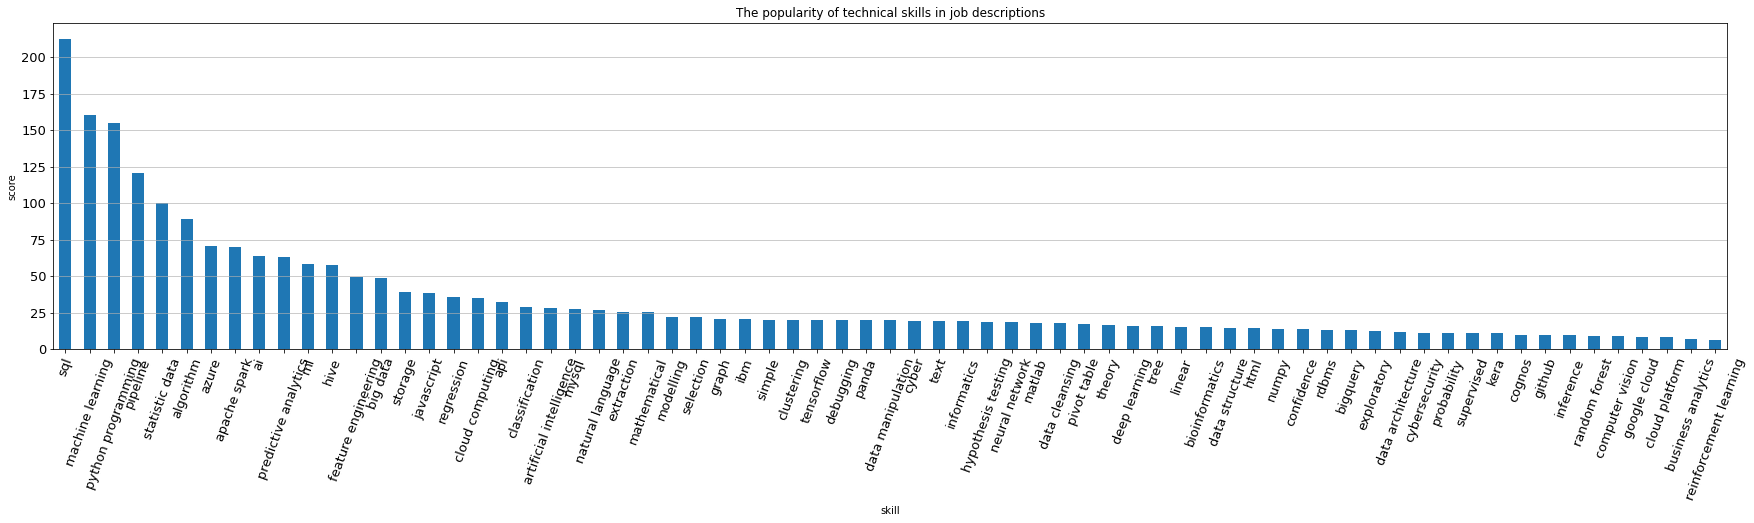

In [ ]:
# technical
tec_hist_df = tec_skill_df.groupby('word').sum()
tec_hist_df = tec_hist_df.sort_values('score', ascending=False)

tec_hist_df.plot(kind='bar',legend=False,rot=70,xlabel='skill',figsize=(30,6),
                 fontsize=13, ylabel='score', title='The popularity of technical skills in job descriptions')
plt.grid(axis='y', alpha=0.8)

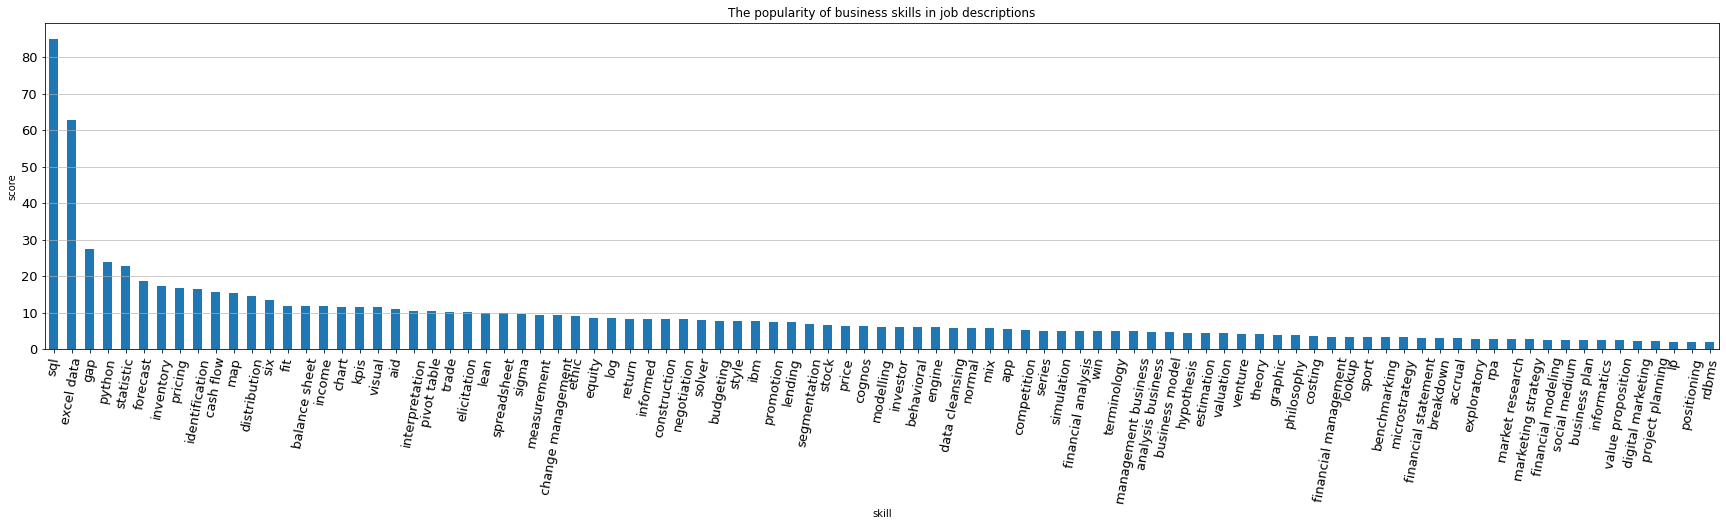

In [ ]:
# business
bus_hist_df = bus_skill_df.groupby('word').sum()
bus_hist_df = bus_hist_df.sort_values('score', ascending=False)

bus_hist_df.plot(kind='bar',legend=False,rot=80,xlabel='skill',figsize=(30,6),
                 fontsize=13, ylabel='score', title='The popularity of business skills in job descriptions')
plt.grid(axis='y', alpha=0.8)

## Graphical visualization

The popularity of data science in different industries

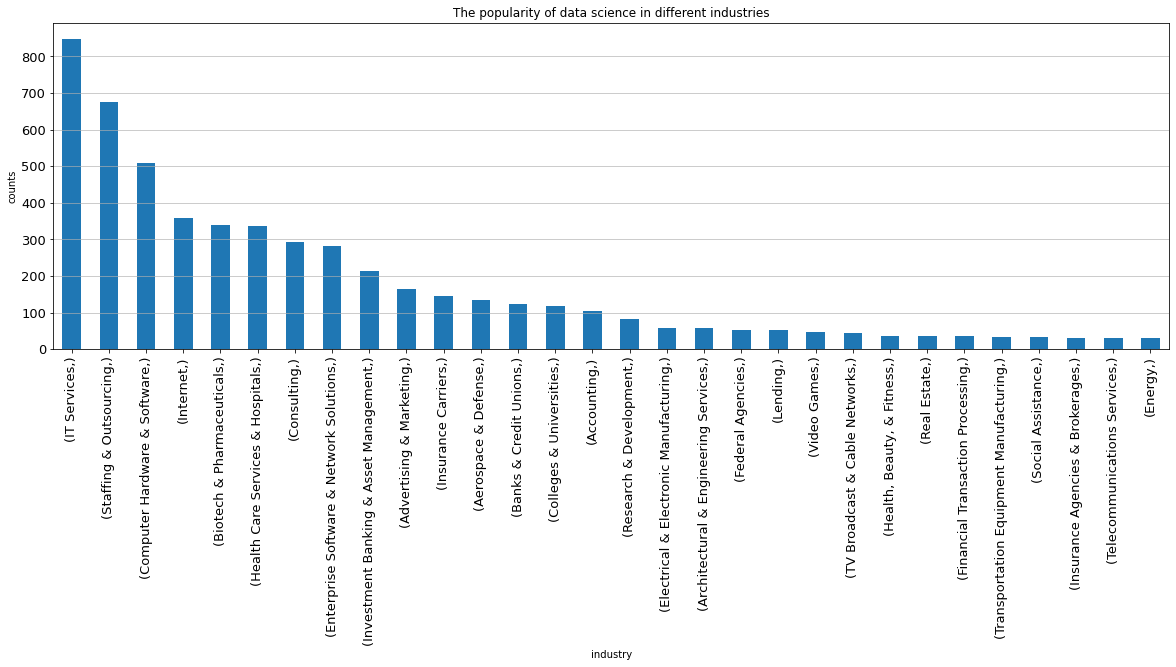

In [ ]:
# get the Industry columns
industry_df = pd.DataFrame(tec_glassdoor_df[['Industry']].value_counts(), columns=['counts']).iloc[1:-1]

# plot histogram and pie chart
# fig, axes = plt.subplots(nrows=1, ncols=2)
industry_df.iloc[0:30].plot(kind='bar',legend=False,rot=90,xlabel='industry',figsize=(20,6),
                 fontsize=13, ylabel='counts', title='The popularity of data science in different industries')
plt.grid(axis='y', alpha=0.8)

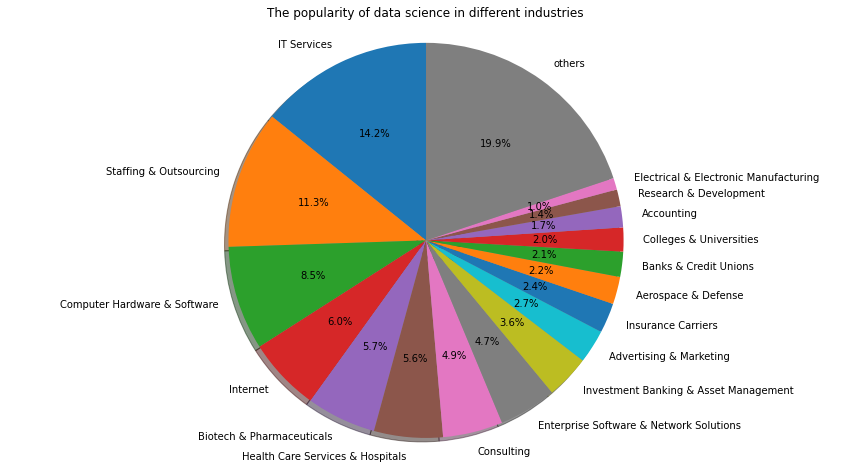

In [ ]:
# collect the inustries after top-17 as otehrs
others = np.sum(industry_df.values[17:-1])

# add others back as a new row 
pie_df = industry_df.iloc[0:17].reset_index()
pie_df = pie_df.append(pd.Series(['others',others], index=pie_df.columns ), ignore_index=True)

# pie chart 
plt.figure(figsize=(15,8))
plt.pie(pie_df.iloc[:,1], labels=pie_df['Industry'].values, autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('The popularity of data science in different industries')
plt.show()


## Technical skills, Onehot Encoding

In [ ]:
# make copy and drop some empty rows
df = tec_df.copy()
df = df[df['untoken'] != ''].reset_index(drop=True)
df = df[df['untoken'] != 'found'].reset_index(drop=True)

# add n-grams to Job_description column
bv = CountVectorizer(ngram_range=(2,2), max_features=500, stop_words=None)
for i in range(0, len(df)):
    bv.fit_transform([df['untoken'][i]])
    df['Job_description'][i] += bv.get_feature_names()

# manually makup some skills
skill_list = tec_skill_df['word'].values.tolist()
skill_list += ['python', 'r', 'c', 'ruby', 'aws', 'nlp', 'machine', 'deep']
onehot_df = pd.DataFrame()
onehot_df['Job_description']=df['Job_description']

for skill in skill_list:
    onehot_df[skill]=0

for i in range(0, len(onehot_df)): # index
    for j in range(1, len(onehot_df.columns)): # column
            skill = onehot_df.columns[j]
            if skill.lower() in onehot_df.iloc[i,0]: 
                onehot_df.iloc[i,j] = 1

onehot_df['machine learning'] = onehot_df['machine']
onehot_df['python programming'] = onehot_df['python']
onehot_df = onehot_df.drop(['Job_description', 'machine', 'python'], axis=1)
onehot_df.head()


,sql,machine learning,python programming,pipeline,statistic data,algorithm,azure,apache spark,ai,predictive analytics,ml,hive,feature engineering,big data,storage,javascript,regression,cloud computing,api,classification,artificial intelligence,mysql,natural language,extraction,mathematical,modelling,selection,graph,ibm,simple,clustering,tensorflow,debugging,panda,data manipulation,cyber,text,informatics,hypothesis testing,neural network,matlab,data cleansing,pivot table,theory,deep learning,tree,linear,bioinformatics,data structure,html,numpy,confidence,rdbms,bigquery,exploratory,data architecture,cybersecurity,probability,supervised,kera,cognos,github,inference,random forest,computer vision,google cloud,cloud platform,business analytics,reinforcement learning,r,c,ruby,aws,nlp,deep
0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Hieratchical Clustering 

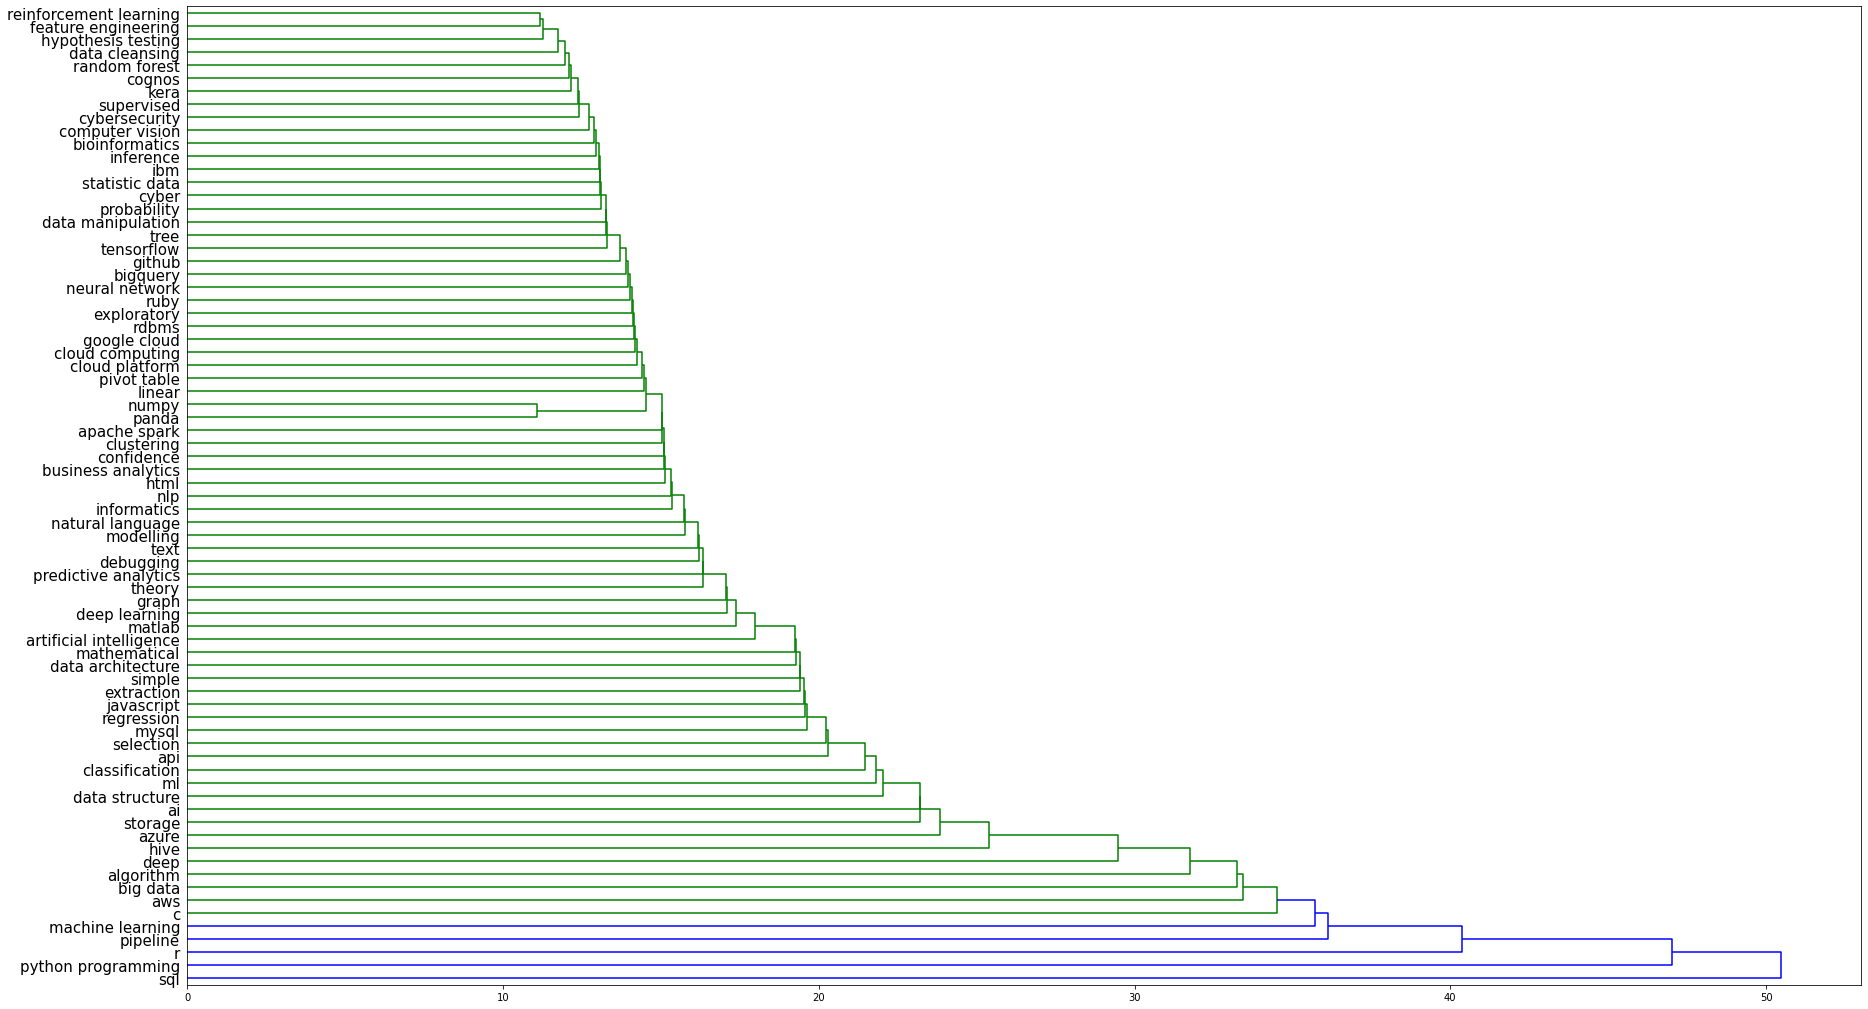

In [ ]:
# Hieratchical Clustering
skill_tech = onehot_df.columns.values
fig, ax = plt.subplots(1,1, figsize=(30, 18))
z = linkage(onehot_df.values.T)
dn = dendrogram(z, orientation='right')
labels = skill_tech[dn['leaves']]
ax.set_yticklabels(labels, fontsize=15)
plt.show()

# Part 4. Recommendation System for Course Selection

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import html
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
nltk.download('stopwords')
nltk.download("wordnet")
nltk.download("averaged_perceptron_tagger")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

## 4.1 Introduction

Since different companies differ in professions, sometimes it can be unnecessary and tedious to go through all the course descriptions for students to choose their directions. So, in this program, we would build a recommendation system to help students select courses based on their demands. The demand could come from the job requirement or their own interest. Students may come from different departments who are interested in data science and excited to find a career related to data science. They may not have sufficient technical skill, and management skill to fit the requirement of data scientist jobs. Therefore, this recommender system brings an insight of helping students make up for their missing skills, and gain competitiveness in the data science field.  


## 4.2 Upload dataset
Our dataset is obtained from the UofT analytics curriculum.

In [ ]:
coursera = pd.read_csv ('course.csv')
coursera

,id,Course Name,Description
0,ECE1513,Introduction to Machine Learning,"An Introduction to the basic theory, the funda..."
1,APS1070,Foundations of Data Analytics and Machine Lear...,This course covers topics fundamental to data ...
2,MIE1624,Introduction to Data Science and Analytics,The objective of the course is to learn analyt...
3,APS1052,A.I. in Finance,"Training and testing workflow: scaling, cross-..."
4,ECE1779,Introduction to Cloud Computing,This course provides an introduction into the ...
5,MIE1628,Big Data Science,This course is designed to provide students wi...
6,MIE1622,Computational Finance and Risk Management,The objective of the course is to examine the ...
7,MIE1723,ENGINEERING ASSET MANAGEMENT,This course is concerned with the determinatio...
8,MIE1727,Statistical Methods in Quality Assurance,wareness of the importance of quality has incr...
9,MIE1512,Data Management for Analytics,This course is a research seminar that focuses...


In [ ]:
# Remove all html tags and attributes (i.e., /<[^>]+>/))
def html_cleaner(text):

  # Using a regex, clean everything inside <>
  cleaner = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
  # apply cleaner to the input text
  cleaned_text = re.sub(cleaner, '', text)
  return cleaned_text

# Remove all URLs
def url_cleaner(text):
  # Using a regex, clean all url
  cleaner = re.compile('\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*')
  # apply cleaner to the input text
  cleaned_text = re.sub(cleaner, '', text)
  return cleaned_text

# Remove non-letter and white space
def non_letter_cleaner(text):
  cleaned_text = re.sub(r'[^a-zA-Z ]+', ' ', text)
  return cleaned_text

def white_space_cleaner(text):
  cleaned_text = re.sub(r'\s+', ' ', text)
  return cleaned_text

# Remove stope words
def stopword_cleaner(text):
  # set stopwords in English
  stop_words = set(stopwords.words("english"))
  # use Reg to spilit the string and remove stopwords
  desp = [word for word in re.findall(r'\w+', text) if word not in stop_words]
  return ' '.join(desp)

# Tokenization & Lemmatization
def lemmatization(text):
  # tokenlization
  tokenizer = RegexpTokenizer(r'\w+')
  lemmatizer = nltk.WordNetLemmatizer()
  text_words = tokenizer.tokenize(text)
  # lemmatization
  desp = [lemmatizer.lemmatize(word) for word in text_words]
  return desp

def Tokenization(text):
  # tokenlization
  tokenizer = RegexpTokenizer(r'\w+')
  text_words = tokenizer.tokenize(text)
  # lemmatization
  desp = [word for word in text_words]

  # add ' ' between words
  return desp

#-------------------------------------------------------------------------------
def text_preprecessing(df, column):
    # step1: Remove all html tags and attributes (i.e., /<[^>]+>/))
    df[column] = df[column].apply(html_cleaner)

    # Step 2: Replace HTML character codes with ASCII equivalent
    df[column] = html.unescape(df[column])

    # Step 3: Remove all URLs
    df[column] = df[column].apply(url_cleaner)

    # Step 4: Lowercase all characters in the text
    df[column] = df[column].str.lower()

    # Step 5: Remove non-letter
    df[column] = df[column].apply(non_letter_cleaner)

    # Step 6: Remove white space
    df[column] = df[column].apply(white_space_cleaner)

    # Step 7: Remove stope words
    df[column] = df[column].apply(stopword_cleaner)

    # Step 8: Tokenization & Lemmatization
    df[column] = df[column].apply(lemmatization)
    # make a untoken copy 
    df['untoken'] = df[column].apply(lambda word:" ".join(word))

    return df

In [ ]:
coursera_cleaned = text_preprecessing(coursera, 'Description')

In [ ]:
coursera_cleaned 

,id,Course Name,Description,untoken
0,ECE1513,Introduction to Machine Learning,"[introduction, basic, theory, fundamental, alg...",introduction basic theory fundamental algorith...
1,APS1070,Foundations of Data Analytics and Machine Lear...,"[course, cover, topic, fundamental, data, anal...",course cover topic fundamental data analytics ...
2,MIE1624,Introduction to Data Science and Analytics,"[objective, course, learn, analytical, model, ...",objective course learn analytical model overvi...
3,APS1052,A.I. in Finance,"[training, testing, workflow, scaling, cross, ...",training testing workflow scaling cross valida...
4,ECE1779,Introduction to Cloud Computing,"[course, provides, introduction, technology, b...",course provides introduction technology behind...
5,MIE1628,Big Data Science,"[course, designed, provide, student, fundament...",course designed provide student fundamental un...
6,MIE1622,Computational Finance and Risk Management,"[objective, course, examine, construction, com...",objective course examine construction computat...
7,MIE1723,ENGINEERING ASSET MANAGEMENT,"[course, concerned, determination, optimal, ma...",course concerned determination optimal mainten...
8,MIE1727,Statistical Methods in Quality Assurance,"[wareness, importance, quality, increased, dra...",wareness importance quality increased dramatic...
9,MIE1512,Data Management for Analytics,"[course, research, seminar, focus, recent, dev...",course research seminar focus recent developme...


## 4.3 Build filter function

In [ ]:
import heapq

def filter(survey_list):
  score_list = []
  for i in range(len(coursera_cleaned)):
    score = 0
    target_list = coursera_cleaned ['Description'].iloc[i]
    for target_word in target_list:
      for key_word in survey_list:
        if (target_word == key_word):
          score += 1
    score_list += [score]
  print('Score list: ',score_list)
  index_list = list(map(score_list.index, heapq.nlargest(3, score_list)))
  print('The course id we choose is', index_list)
  print('The courses we recommend are {}, {} and {}.'.format(coursera_cleaned['Course Name'].iloc[index_list[0]],
                                                             coursera_cleaned['Course Name'].iloc[index_list[1]],
                                                             coursera_cleaned['Course Name'].iloc[index_list[2]]))
  return score_list


## 4.4 Questionnaire for student 

We list five questions to ask for some information of the students, and help them to find the needed courses.

In [ ]:
survey_list=[]

#### Question 1: What kind of job do you want to find? (eg. big data, machine learning, natural language processing, ex..)

In [ ]:
keyword=input()
survey_list.append(keyword)

data


#### Question 2: what kind of programming language do you want to learn? (eg. python, java, R, SQL, ex..)

In [ ]:
keyword=input()
survey_list.append(keyword)

java


#### Question 3: What kind of skills do you need to learn for your future career? (eg. visualization, mathematics, SAS, ...ex )

In [ ]:
keyword=input()
survey_list.append(keyword)

visulization


#### Question 4: What kind of management ability do you need to learn for your future career? (eg. decision making, teamwork, presentation,...ex )

In [ ]:
keyword=input()
survey_list.append(keyword)

presentation


#### Question 5: What else knowledge do you want to learn to improve yourself? (eg. you can type nothing or linear optimization ex.. )

In [ ]:
keyword=input()
survey_list.append(keyword)

optimization


## 4.6 Recommendations

In [ ]:
# survey_list = ['data', 'pyhton', 'ai', 'presentation', 'optimization']
score_list = filter(survey_list)

Score list:  [0, 3, 5, 0, 0, 12, 3, 1, 0, 10]
The course id we choose is [5, 9, 2]
The courses we recommend are Big Data Science, Data Management for Analytics and Introduction to Data Science and Analytics.


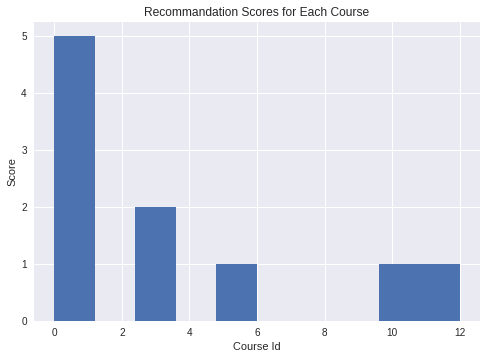

In [ ]:
x = score_list
plt.style.use('seaborn')
plt.hist(x, bins=10)
plt.ylabel('Score')
plt.xlabel('Course Id')
plt.title('Recommandation Scores for Each Course')
plt.show()